In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle

In [2]:
train_set = pd.read_csv('../02_LimpiezaEDA/train_set_clean.csv')
test_set = pd.read_csv('../02_LimpiezaEDA/test_set_clean.csv')



Para trabajar con un modelo mixto (regresión y clasificación), crearemos dos target diferenciados. El primero para la clasificación con una nueva feature 'has_revenue' y para la regresión aplicaremos una transformación logarítmica en revenue debido a la distribución asimétrica que presenta.

In [3]:
# Target para clasificación ¿Tiene revenue?
train_set['has_revenue'] = (train_set['revenue'] > 0).astype(int)
test_set['has_revenue'] = (test_set['revenue'] > 0).astype(int)

# Target para regresión log(revenue) solo para películas con revenue > 0
train_revenue = train_set[train_set['revenue'] > 0].copy()
train_revenue['log_revenue'] = np.log(train_revenue['revenue'])
test_revenue = test_set[test_set['revenue'] > 0].copy()
test_revenue['log_revenue'] = np.log(test_revenue['revenue'])

Lo siguiente será crear dos variables que no contengan el target y sus columnas homólogas que hemos creado.

In [4]:
# Para la claasificación

cols_drop = ['title', 'revenue', 'has_revenue', 'log_revenue']
X_train_clf = train_set.drop(columns=[col for col in cols_drop if col in train_set.columns])
y_train_clf = train_set['has_revenue']
X_test_clf = test_set.drop(columns=[col for col in cols_drop if col in test_set.columns])
y_test_clf = test_set['has_revenue']

# Para la regresión

X_train_reg = train_revenue.drop(columns=[col for col in cols_drop if col in train_revenue.columns])
y_train_reg = train_revenue['log_revenue']
X_test_reg = test_revenue.drop(columns=[col for col in cols_drop if col in test_revenue.columns])
y_test_reg = test_revenue['log_revenue']

---
# Preprocesar

---


Es el momento de hacer el preprocesado de nuestros datos.
En el EDA observamos que varias columnas numéricas presentaban una distribución asimétrica (budget, vote_count y popularity, ahora log_popularity).
Por otro lado, en la columna original_language (ahora language_category) segmentamos los 9 idiomas más importantes y agrupamos el resto en "other", con el objetivo de aplicar un OneHotEncoder.


In [5]:
# Variables a escalar

num_scaled = ['budget', 'vote_count', 'log_popularity']
num_no_scaled = ['runtime', 'vote_average', 'release_year', 
                 'release_month', 'num_genres', 'num_famous_actors']
cat_features = ['language_category']
binary_features = ['is_franchise', 'has_famous_actor', 'is_usa_production', 
                   'has_major_studio', 'genre_action', 'genre_adventure',
                   'genre_animation', 'genre_comedy', 'genre_horror', 
                   'genre_drama', 'genre_family', 'genre_fantasy',
                   'genre_science_fiction', 'genre_thriller']


In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), num_scaled),
        ('num_no_scaled', 'passthrough', num_no_scaled),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features),
        ('bin', 'passthrough', binary_features)
    ])


---

# Modelos de ML

---

A continuación, haremos un análisis de diferentes algoritmos de Machine learning para ver cuál se ajusta mejor a la naturaleza de nuestros datos.

Como es un modelo mixto, empezaremos por la clasificación de nuestras péliculas, es decir, si obtienen revenue o no (plataformas o estrenos).

Para clasificar utilizaremos: LogisticRegression, RandomForest y XGBoost.
Se ajustarán mejor a nuestros datos que otros algoritmos (tenemos muchas features).


* LogisticRegression

In [7]:
# Clasificación
# Empezaremos por LogisticRegression()

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Lo entrenamos

pipeline_lr.fit(X_train_clf, y_train_clf)

# Predecimos y evaluamos los resultados

y_pred_lr = pipeline_lr.predict(X_test_clf)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test_clf)[:, 1]

print(" Accuracy: ", accuracy_score(y_test_clf, y_pred_lr))
print(" Precision: ", precision_score(y_test_clf, y_pred_lr))
print(" Recall: ",recall_score(y_test_clf, y_pred_lr))
print(" F1 score: ",f1_score(y_test_clf, y_pred_lr))
print(" ROC: ", roc_auc_score(y_test_clf, y_pred_proba_lr))






c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


 Accuracy:  0.7324478178368121
 Precision:  0.9041666666666667
 Recall:  0.6477611940298508
 F1 score:  0.7547826086956522
 ROC:  0.8500932835820896


In [8]:
# Guardamos las métricas

accuracy_lr = accuracy_score(y_test_clf, y_pred_lr)
precision_lr = precision_score(y_test_clf, y_pred_lr)
recall_lr = recall_score(y_test_clf, y_pred_lr)
f1_lr = f1_score(y_test_clf, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test_clf, y_pred_proba_lr)
lr_metrics = {
    'Modelo': 'Logistic Regression',
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr,
    'ROC-AUC': roc_auc_lr
}


LogisticRegression muestra un modelo "conservador" con alta precisión 
(0.90) pero bajo recall (0.64). Cuando predice que una película tendrá 
revenue, acierta el 90% de las veces, pero solo detecta el 64% de las 
películas que realmente tienen revenue.
Por otro lado ROC-AUC (0.85) indica una óptima capacidad 
de discriminación entre clases.

* RandomForest

In [9]:
# Clasificación
# RandomForest

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=5,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Lo entrenamos

pipeline_rf.fit(X_train_clf, y_train_clf)

# Predecimos y evaluamos los resultados

y_pred_rf = pipeline_rf.predict(X_test_clf)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test_clf)[:, 1]

print("accuracy :", accuracy_score(y_test_clf, y_pred_rf))
print ("precision :", precision_score(y_test_clf, y_pred_rf))
print("recall :", recall_score(y_test_clf, y_pred_rf))
print("f1 sore :", f1_score(y_test_clf, y_pred_rf))
print( "ROC:", roc_auc_score(y_test_clf, y_pred_proba_rf))

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


accuracy : 0.7912713472485768
precision : 0.915129151291513
recall : 0.7402985074626866
f1 sore : 0.8184818481848185
ROC: 0.8835976368159204


In [10]:
# Guardamos las métricas

accuracy_rf = accuracy_score(y_test_clf, y_pred_rf)
precision_rf = precision_score(y_test_clf, y_pred_rf)
recall_rf = recall_score(y_test_clf, y_pred_rf)
f1_rf = f1_score(y_test_clf, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_clf, y_pred_proba_rf)
rf_metrics = {
    'Modelo': 'Random Forest',
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'ROC-AUC': roc_auc_rf
}

Vemos que RandomForest presenta métricas similares, pero siempre mejores que LogisticRegression. El recall pasa del 64% al 74% (LogisticRegression y RandomForest), lo que indica que detecta mejor las películas que tienen revenue (!= 0).
En ambos modelos, predecimos con un acierto cercano al 90% cuando el modelo determina que sí tiene revenue.
El ROC-AUC (0.88) obtiene un pequeño aumento porcentual


* XGBoost


In [11]:
# Clasificación
# XGBoost

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5
    ))
])

# Lo entrenamos
pipeline_xgb.fit(X_train_clf, y_train_clf)

# Predecimos y evaluamos
y_pred_xgb = pipeline_xgb.predict(X_test_clf)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test_clf)[:, 1]

print("accuracy :", accuracy_score(y_test_clf, y_pred_xgb))
print("precision :", precision_score(y_test_clf, y_pred_xgb))
print("recall :", recall_score(y_test_clf, y_pred_xgb))
print("f1 score :", f1_score(y_test_clf, y_pred_xgb))
print("ROC:", roc_auc_score(y_test_clf, y_pred_proba_xgb))

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


accuracy : 0.8121442125237192
precision : 0.8986486486486487
recall : 0.7940298507462686
f1 score : 0.8431061806656102
ROC: 0.8880286069651742


In [12]:
# Guardamos las métricas

accuracy_xgb = accuracy_score(y_test_clf, y_pred_xgb)
precision_xgb = precision_score(y_test_clf, y_pred_xgb)
recall_xgb = recall_score(y_test_clf, y_pred_xgb)
f1_xgb = f1_score(y_test_clf, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test_clf, y_pred_proba_xgb)

xgb_metrics = {
    'Modelo': 'XGBoost',
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1-Score': f1_xgb,
    'ROC-AUC': roc_auc_xgb
}

XGBoost presenta el mejor desempeño de los tres modelos (mejores estadísticas en 4 de las 5 métricas).
Detecta el 79% de las películas con revenue (recall).
El ROC-AUC sigue aumentando, alcanzando el valor más alto entre los tres modelos, con un 88%.
Solo empeora respecto a RandomForest y LogisticRegression en la precisión, pero aun así mantiene un muy buen porcentaje del 89%.

Antes de empezar a ajustar los hiperparámetros del mejor modelo, hasta ahora XGBoost, haremos un breve análisis del posible overfitting de cada uno de ellos.

In [13]:
# Overfitting

# Logistic Regression
y_pred_train_lr = pipeline_lr.predict(X_train_clf)
train_acc_lr = accuracy_score(y_train_clf, y_pred_train_lr)
test_acc_lr = accuracy_lr

print("Logistic Regression")
print("Train accuracy: ", train_acc_lr)
print("Test accuracy: ", test_acc_lr)
print("Diferencia: ", train_acc_lr - test_acc_lr)

# Random Forest
y_pred_train_rf = pipeline_rf.predict(X_train_clf)
train_acc_rf = accuracy_score(y_train_clf, y_pred_train_rf)
test_acc_rf = accuracy_rf

print("RandomForest")
print("Train accuracy: ", train_acc_rf)
print("Test accuracy: ", test_acc_rf)
print("Diferencia: ", train_acc_rf - test_acc_rf)

# XGBoost
y_pred_train_xgb = pipeline_xgb.predict(X_train_clf)
train_acc_xgb = accuracy_score(y_train_clf, y_pred_train_xgb)
test_acc_xgb = accuracy_xgb

print("XGBoost")
print("Train accuracy: ",train_acc_xgb)
print("Test accuracy:", test_acc_xgb)
print("Diferencia: ", train_acc_xgb - test_acc_xgb)


Logistic Regression
Train accuracy:  0.7695570216776626
Test accuracy:  0.7324478178368121
Diferencia:  0.03710920384085048
RandomForest
Train accuracy:  0.8393025447690857
Test accuracy:  0.7912713472485768
Diferencia:  0.048031197520508884
XGBoost
Train accuracy:  0.9227144203581527
Test accuracy: 0.8121442125237192
Diferencia:  0.1105702078344335


En relación con el overfitting, el modelo más seguro de implementar es RandomForest. A pesar de que presenta métricas inferiores a XGBoost, muestra una diferencia menor entre entrenamiento y validación (0.048 para RandomForest frente a 0.11 para XGBoost).
Diferencias próximas a 0.15 implican un riesgo moderado de overfitting.
Por lo tanto, nos quedaremos con RandomForest y ajustaremos sus hiperparámetros. Para ello, utilizaremos GridSearchCV.

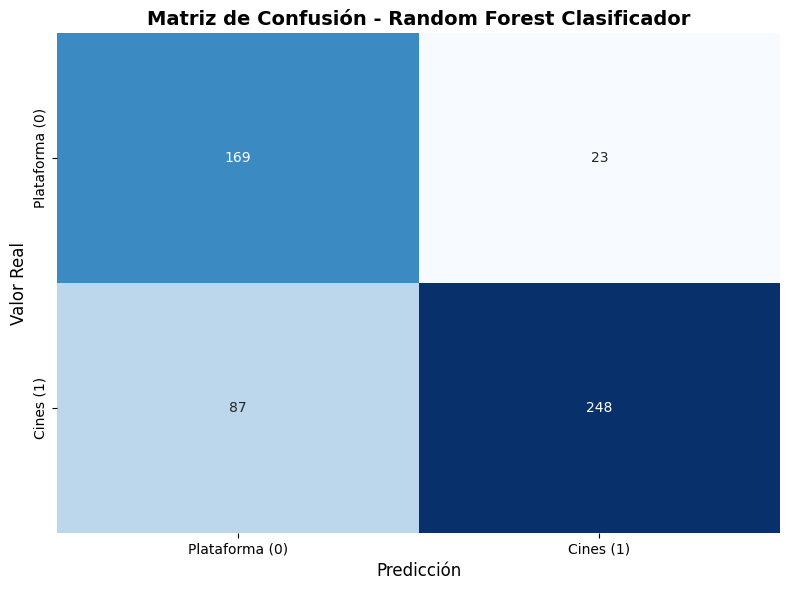

In [60]:
# Matriz de condusión Random Forest

cm = confusion_matrix(y_test_clf, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Plataforma (0)', 'Cines (1)'],
            yticklabels=['Plataforma (0)', 'Cines (1)'])
plt.title('Matriz de Confusión - Random Forest Clasificador', fontsize=14, weight='bold')
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show();

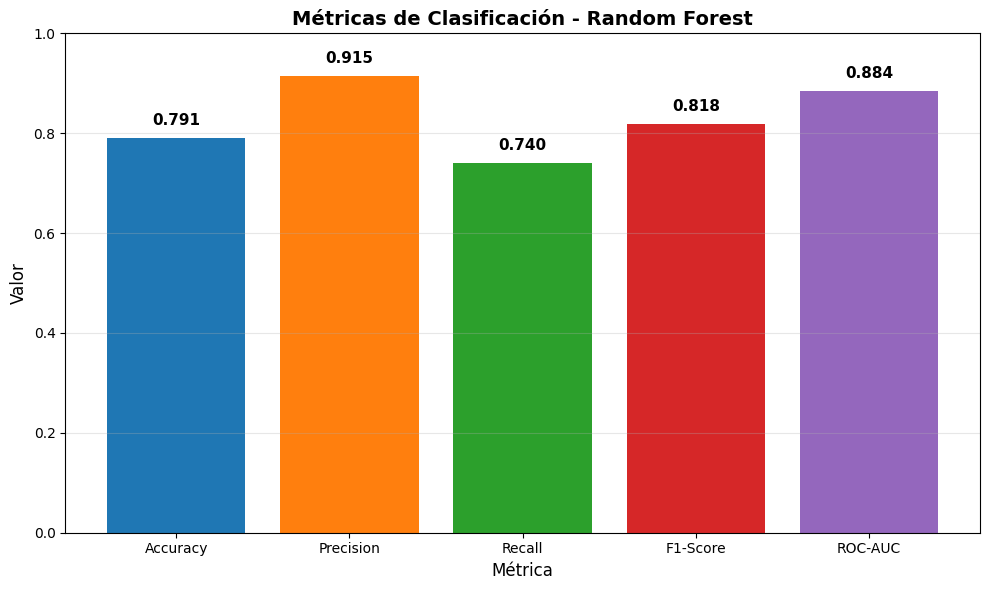

In [61]:
# Gráfico de métricas

metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
valores = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf]

plt.figure(figsize=(10, 6))
bars = plt.bar(metricas, valores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim(0, 1)
plt.title('Métricas de Clasificación - Random Forest', fontsize=14, weight='bold')
plt.ylabel('Valor', fontsize=12)
plt.xlabel('Métrica', fontsize=12)

# Añadimos valores encima de cada barra

for i, (bar, valor) in enumerate(zip(bars, valores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{valor:.3f}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show();

Momento de reflexionar qué métrica debemos buscar, poniéndonos en la tesitura de negocio:

* Accuracy (% de decisiones correctas tanto en cines como en streaming).
No tendría sentido porque trata todos los errores por igual, sin considerar que equivocarse en una película de éxito (perder una oportunidad) puede tener mayor coste que equivocarse en una fallida (inversión desperdiciada).

* Precision (de las películas que decidimos llevar a cines, ¿cuántas realmente funcionan?).
La podríamos considerar si negocio exigiese minimizar pérdidas. Sin embargo, al tener puntuaciones en esta métrica tan altas, el modelo tendería a no estrenar en salas una gran cantidad de películas que podrían ser de éxito.

* Recall (de todas las películas que deberían ir a cines, ¿cuántas detectamos?).
Esta métrica parece un poco arriesgada también. Los modelos presentaban recall de entre 64% y 79%, lo que significa que dejamos escapar entre un 21% y un 36% de películas con potencial de éxito, representando oportunidades perdidas significativas.

* F1-score (balance entre Precision y Recall).
Ofrece un equilibrio entre minimizar pérdidas (Precision) y maximizar oportunidades (Recall), lo cual puede ser de interés para negocio.

* ROC-AUC (¿qué tan bien ordena el modelo las películas por probabilidad?).
Aporta la mayor flexibilidad, ya que no impone un umbral de decisión (threshold).
Permite a negocio tomar diferentes estrategias según el tipo de estreno.
Pueden ajustar el umbral según el contexto: un umbral alto prioriza Precision (solo estrenamos cuando estamos muy seguros), mientras que un umbral bajo prioriza Recall (capturamos más oportunidades asumiendo más riesgo).
El modelo sigue siendo válido independientemente de la estrategia, permitiendo al equipo de negocio ajustar decisiones según presupuesto y contexto del mercado sin necesidad de reentrenarlo.



In [14]:
# Definimos los hiperparámetros

param_grid_clf = {
    'classifier__n_estimators': [200, 300, 500],
    'classifier__max_depth': [5, 7, 10],
    'classifier__min_samples_split': [5, 10, 20],
    'classifier__min_samples_leaf': [2, 5, 10]
}

grid_search_clf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_clf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [15]:
# Entrenamos

grid_search_clf.fit(X_train_clf, y_train_clf)

# Análisis de los hiperparámetros

for param, value in grid_search_clf.best_params_.items():
    print(f"   {param}: {value}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [5, 7, ...], 'classifier__min_samples_leaf': [2, 5, ...], 'classifier__min_samples_split': [5, 10, ...], 'classifier__n_estimators': [200, 300, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"


   classifier__max_depth: 10
   classifier__min_samples_leaf: 2
   classifier__min_samples_split: 10
   classifier__n_estimators: 500


In [16]:
# Evaluamos el mejor modelo en test

best_score_rf_clf = grid_search_clf.best_score_
best_rf_clf = grid_search_clf.best_estimator_
print(best_score_rf_clf)


y_pred_best_rf = best_rf_clf.predict(X_test_clf)
y_pred_proba_best_rf = best_rf_clf.predict_proba(X_test_clf)[:, 1]

# Calculamos métricas
accuracy_best_rf = accuracy_score(y_test_clf, y_pred_best_rf)
precision_best_rf = precision_score(y_test_clf, y_pred_best_rf)
recall_best_rf = recall_score(y_test_clf, y_pred_best_rf)
f1_best_rf = f1_score(y_test_clf, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test_clf, y_pred_proba_best_rf)

# Visualizamos

print(" Accuracy: ", accuracy_best_rf)
print(" Precision: ", precision_best_rf)
print(" Recall: ", recall_best_rf)
print(" F1-Score: ", f1_best_rf)
print(" ROC-AUC: ", roc_auc_best_rf)

0.8973702513702513
 Accuracy:  0.8007590132827325
 Precision:  0.9107142857142857
 Recall:  0.7611940298507462
 F1-Score:  0.8292682926829268
 ROC-AUC:  0.8905628109452736


In [17]:
# Verificar overfitting
y_pred_train_best_rf = best_rf_clf.predict(X_train_clf)
train_acc_best_rf = accuracy_score(y_train_clf, y_pred_train_best_rf)

print("Train accuracy: ", train_acc_best_rf)
print("Test accuracy: ", accuracy_best_rf)
print("Diferencia: ", train_acc_best_rf - accuracy_best_rf)


Train accuracy:  0.8751178133836004
Test accuracy:  0.8007590132827325
Diferencia:  0.07435880010086793


Pasaremos a la regresión para pedecir el revenue. Utilizaremos: Linear Regression (Ridge con regularización L2 y Lasso con regularización L1 para feature selection), RandomForest y XGBoost.

* Ridge Linear Regression

In [18]:
# Regresión
# Ridge

pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42, alpha=1.0))
])

# Entrenamos
pipeline_ridge.fit(X_train_reg, y_train_reg)

# Predecimos
y_pred_log_ridge = pipeline_ridge.predict(X_test_reg)
y_pred_ridge = np.exp(y_pred_log_ridge)
y_test_original = np.exp(y_test_reg)

# Calculamos métricas
rmse_ridge = np.sqrt(mean_squared_error(y_test_original, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test_original, y_pred_ridge)
r2_ridge = r2_score(y_test_original, y_pred_ridge)

# Imprimimos
print("RMSE: $", rmse_ridge/1e6, "M")
print("MAE: $", mae_ridge/1e6, "M")
print("R²:", r2_ridge)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


RMSE: $ 690.2588742295176 M
MAE: $ 194.6304767802392 M
R²: -5.217272537958196


In [19]:
# Guardamos las métricas

ridge_metrics = {
    'Modelo': 'Ridge',
    'RMSE': rmse_ridge,
    'MAE': mae_ridge,
    'R²': r2_ridge
}

In [20]:
# Regresión
# Lasso

pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(random_state=42, alpha=1.0))
])

# Entrenamos
pipeline_lasso.fit(X_train_reg, y_train_reg)

# Predecimos
y_pred_log_lasso = pipeline_lasso.predict(X_test_reg)
y_pred_lasso = np.exp(y_pred_log_lasso)

# Calculamos métricas
rmse_lasso = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test_original, y_pred_lasso)
r2_lasso = r2_score(y_test_original, y_pred_lasso)

# Imprimimos
print("RMSE: $", rmse_lasso/1e6, "M")
print("MAE: $", mae_lasso/1e6, "M")
print("R²:", r2_lasso)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


RMSE: $ 276.3159708076551 M
MAE: $ 138.49851310002023 M
R²: 0.003705156237212126


In [21]:
# Guardamos las métricas

lasso_metrics = {
    'Modelo': 'Lasso',  
    'RMSE': rmse_lasso,
    'MAE': mae_lasso,
    'R²': r2_lasso
}

Los modelos lineales Ridge y Lasso se utilizan como base para evaluar el 
rendimiento mínimo antes de aplicar modelos más complejos.
Resultados: Ridge: R² = -5.22, RMSE = $690M y Lasso R² = 0.004, RMSE = $276M
Ambos modelos muestran rendimiento muy limitado. Ridge obtiene R² negativo, 
indicando predicciones peores que simplemente usar la media. Lasso apenas 
explica el 0.4% de la varianza.
Este bajo rendimiento es esperado dado que las relaciones entre features y 
revenue son no lineales. Una película de franquicia con budget alto genera 
revenue de forma exponencial, no proporcional.
Estos resultados confirman la necesidad de algoritmos basados en árboles 
(Random Forest, XGBoost) para capturar relaciones complejas.

* K-Nearest Neighbors (KNN)

In [22]:
# Regresión
# K-Nearest Neighbors

pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_neighbors=5,
        weights='uniform',
        metric='euclidean'
    ))
])

# Lo entrenamos

pipeline_knn.fit(X_train_reg, y_train_reg)

# Predecimos y evaluamos

y_pred_log_knn = pipeline_knn.predict(X_test_reg)
y_pred_knn = np.exp(y_pred_log_knn)

rmse_knn = np.sqrt(mean_squared_error(y_test_original, y_pred_knn))
mae_knn = mean_absolute_error(y_test_original, y_pred_knn)
r2_knn = r2_score(y_test_original, y_pred_knn)

print("RMSE: $", rmse_knn/1e6, "M")
print("MAE: $", mae_knn/1e6, "M")
print("R²:", r2_knn)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


RMSE: $ 226.47717954706954 M
MAE: $ 112.06060791973421 M
R²: 0.33069386865825934


In [23]:
# Guardamos las métricas

knn_metrics = {
    'Modelo': 'KNN',
    'RMSE': rmse_knn,
    'MAE': mae_knn,
    'R²': r2_knn
}

K-Nearest Neighbors muestra rendimiento limitado en este problema:
R² de (0.33) Explica solo el 33% de la varianza en revenue.
KNN presenta dificultades debido a que con 24 features, el concepto de "vecino cercano" pierde significado. Películas que parecen similares en algunas dimensiones pueden ser muy diferentes en otras. La distancia en 24 dimensiones no captura adecuadamente la similitud real entre películas. A esto se suma que KNN trata a todas las columnas por igual, sigue siendo un modelo sencillo para nuestro dataset.
Pasamos a los Trees.

* Random Forest


In [24]:
# Regresión
# Random Forest

pipeline_rf_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_estimators=100,
        max_depth=5,
        n_jobs=-1
    ))
])

# Lo entrenamos

pipeline_rf_reg.fit(X_train_reg, y_train_reg)

# Predecimos y evaluamos

y_pred_log_rf_reg = pipeline_rf_reg.predict(X_test_reg)
y_pred_rf_reg = np.exp(y_pred_log_rf_reg)

rmse_rf_reg = np.sqrt(mean_squared_error(y_test_original, y_pred_rf_reg))
mae_rf_reg = mean_absolute_error(y_test_original, y_pred_rf_reg)
r2_rf_reg = r2_score(y_test_original, y_pred_rf_reg)

print("RMSE: $", rmse_rf_reg/1e6, "M")
print("MAE: $", mae_rf_reg/1e6, "M")
print("R²:", r2_rf_reg)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


RMSE: $ 151.50611902926596 M
MAE: $ 71.29327639369158 M
R²: 0.7004728082757391


In [25]:
# Guardamos las métricas

rf_reg_metrics = {
    'Modelo': 'Random Forest',
    'RMSE': rmse_rf_reg,
    'MAE': mae_rf_reg,
    'R²': r2_rf_reg
}

Random Forest Regressor muestra una mejora drástica respecto a los modelos lineales. Pasamos de un R² con Linear Regression negativo o cercano al 0.003% a un 70%. Recordemos que R² explica la varianza en revenue.
Por otro lado, tenemos un RMSE = $151M (error típico de 151 millones por película) y un MAE = $71M (error promedio de 71 millones).
La mejora se debe a la capacidad de Random Forest para capturar relaciones no lineales e interacciones entre features.
Con R² = 0.70, el modelo tiene suficiente poder predictivo para ser útil en decisiones de negocio, aunque deja un 30% de varianza sin explicar (con unos parámetros muy básicos).

* XGBoost Regressor

In [26]:
# Regresión
# XGBoost

pipeline_xgb_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5
    ))
])

# Lo entrenamos

pipeline_xgb_reg.fit(X_train_reg, y_train_reg)

# Predecimos y evaluamos

y_pred_log_xgb_reg = pipeline_xgb_reg.predict(X_test_reg)
y_pred_xgb_reg = np.exp(y_pred_log_xgb_reg)

rmse_xgb_reg = np.sqrt(mean_squared_error(y_test_original, y_pred_xgb_reg))
mae_xgb_reg = mean_absolute_error(y_test_original, y_pred_xgb_reg)
r2_xgb_reg = r2_score(y_test_original, y_pred_xgb_reg)

print("RMSE: $", rmse_xgb_reg/1e6, "M")
print("MAE: $", mae_xgb_reg/1e6, "M")
print("R²:", r2_xgb_reg)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


RMSE: $ 139.8814722377646 M
MAE: $ 68.46886092445193 M
R²: 0.744673261964372


In [27]:
# Guardamos las métricas

xgb_reg_metrics = {
    'Modelo': 'XGBoost',
    'RMSE': rmse_xgb_reg,
    'MAE': mae_xgb_reg,
    'R²': r2_xgb_reg
}

In [28]:
# Overfitting

# Ridge
y_pred_train_log_ridge = pipeline_ridge.predict(X_train_reg)
y_pred_train_ridge = np.exp(y_pred_train_log_ridge)
y_train_original = np.exp(y_train_reg)
r2_train_ridge = r2_score(y_train_original, y_pred_train_ridge)

print("Ridge")
print("Train R²:", r2_train_ridge)
print("Test R²: ", r2_ridge)
print("Diferencia: ", r2_train_ridge - r2_ridge)

# Lasso
y_pred_train_log_lasso = pipeline_lasso.predict(X_train_reg)
y_pred_train_lasso = np.exp(y_pred_train_log_lasso)
r2_train_lasso = r2_score(y_train_original, y_pred_train_lasso)

print("Lasso")
print("Train R²:", r2_train_lasso)
print("Test R²: ", r2_lasso)
print("Diferencia: ", r2_train_lasso - r2_lasso)

# Random Forest
y_pred_train_log_rf = pipeline_rf_reg.predict(X_train_reg)
y_pred_train_rf = np.exp(y_pred_train_log_rf)
r2_train_rf_reg = r2_score(y_train_original, y_pred_train_rf)

print("Random Forest")
print("Train R²: ", r2_train_rf_reg)
print("Test R²: ", r2_rf_reg)
print("Diferencia: ", r2_train_rf_reg - r2_rf_reg)

# XGBoost
y_pred_train_log_xgb = pipeline_xgb_reg.predict(X_train_reg)
y_pred_train_xgb = np.exp(y_pred_train_log_xgb)
r2_train_xgb_reg = r2_score(y_train_original, y_pred_train_xgb)

print("XGBoost")
print("Train R²: ", r2_train_xgb_reg)
print("Test R²: ", r2_xgb_reg)
print("Diferencia:", r2_train_xgb_reg - r2_xgb_reg)

Ridge
Train R²: -27.075044896743943
Test R²:  -5.217272537958196
Diferencia:  -21.85777235878575
Lasso
Train R²: 0.07796566274308026
Test R²:  0.003705156237212126
Diferencia:  0.07426050650586813
Random Forest
Train R²:  0.6963965372505438
Test R²:  0.7004728082757391
Diferencia:  -0.004076271025195255
XGBoost
Train R²:  0.8877004453872079
Test R²:  0.744673261964372
Diferencia: 0.14302718342283594


En relación con el overfitting, el modelo más seguro es Random Forest. Aunque 
XGBoost presenta mejor R² en test (0.745 y 0.700 respectivamente), Random Forest muestra una 
diferencia prácticamente nula entre entrenamiento y test (-0.004), indicando 
generalización perfecta.
XGBoost, por su parte, presenta una diferencia del 14.3%, sugiriendo un riesgo de overfitting moderado.
Seleccionaremos Random Forest para optimización mediante GridSearchCV.
El modelo ya explica el 70% de la varianza en revenue, un resultado sólido para predicción de taquilla a falta de perfeccionar sus hiperparámetros.
Es destacable destacar RandomForest de por sí es resistente al overfitting.

Para regresión, optimizaremos usando R² como métrica objetivo. R² nos cuenta que el modelo explica el 70% de las diferencias en revenue entre películas, dejando un 30% atribuible a factores externos no capturados por nuestras features.
Ventaja sobre RMSE y MAE: Estas métricas miden el error en dólares, pero su interpretación depende del contexto. ¿Es $140M de error mucho o poco? Depende de si el revenue promedio es $50M o $500M.
R², en cambio, es independiente de la escala y más interpretable: 
cuanto más cercano a 1.0, mejor capacidad predictiva. Esto permite comparar 
objetivamente modelos y datasets diferentes.

In [29]:
# Definimos los hiperparámetros

param_grid_reg = {
    'regressor__n_estimators': [200, 300, 500],
    'regressor__max_depth': [5, 7, 10],
    'regressor__min_samples_split': [5, 10, 20],
    'regressor__min_samples_leaf': [2, 5, 10]
}

grid_search_reg = GridSearchCV(
    estimator=pipeline_rf_reg,
    param_grid=param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [30]:
# Entrenar

grid_search_reg.fit(X_train_reg, y_train_reg)

# Análisis de los hiperparámetros

print("Mejores Hiperparámetros:")
for param, value in grid_search_reg.best_params_.items():
    print(f"   {param}: {value}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [5, 7, ...], 'regressor__min_samples_leaf': [2, 5, ...], 'regressor__min_samples_split': [5, 10, ...], 'regressor__n_estimators': [200, 300, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"


Mejores Hiperparámetros:
   regressor__max_depth: 10
   regressor__min_samples_leaf: 2
   regressor__min_samples_split: 5
   regressor__n_estimators: 500


In [31]:
# Evaluamos el mejor modelo en test

best_rf_reg = grid_search_reg.best_estimator_

y_pred_best_rf_reg = best_rf_reg.predict(X_test_reg)
y_pred_best_rf_reg_original = np.exp(y_pred_best_rf_reg)

# Calculamos métricas

r2_best_rf_reg = r2_score(y_test_original, y_pred_best_rf_reg_original)
rmse_best_rf_reg = np.sqrt(mean_squared_error(y_test_original, y_pred_best_rf_reg_original))
mae_best_rf_reg = mean_absolute_error(y_test_original, y_pred_best_rf_reg_original)

# Visualizamos

print("Métricas en test:")
print("R²: ", r2_best_rf_reg)
print("RMSE: ", rmse_best_rf_reg/1e6)
print("MAE: ", mae_best_rf_reg/1e6)

Métricas en test:
R²:  0.7391476289891536
RMSE:  141.3869872569003
MAE:  67.81582735431694


In [32]:
# Verificamos overfitting del modelo optimizado

y_pred_train_best_rf = best_rf_reg.predict(X_train_reg)
y_pred_train_best_rf_original = np.exp(y_pred_train_best_rf)
y_train_original = np.exp(y_train_reg)
r2_train_best_rf_reg = r2_score(y_train_original, y_pred_train_best_rf_original)

print("Overfitting")
print("Train R²: ", r2_train_best_rf_reg)
print("Test R²: ", r2_best_rf_reg)
print("Diferencia: ", r2_train_best_rf_reg - r2_best_rf_reg)

Overfitting
Train R²:  0.8727026808676552
Test R²:  0.7391476289891536
Diferencia:  0.13355505187850158


Puesto que hay un riesgo de overfitting moderado (<0.15), procederemos a aplicar GridSearchCV en XGBoost, a pesar de que ya tiene el mismo riesgo:
Compararemos ambos modelos.

In [33]:
# Definimos los hiperparámetros

param_grid_xgb_reg = {
    'regressor__n_estimators': [300, 500, 700],
    'regressor__max_depth': [5, 7, 10],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 0.9],
    'regressor__colsample_bytree': [0.8, 0.9]
}

grid_search_xgb_reg = GridSearchCV(
    estimator=pipeline_xgb_reg,
    param_grid=param_grid_xgb_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [34]:
# Entrenar

grid_search_xgb_reg.fit(X_train_reg, y_train_reg)

# Análisis de los hiperparámetros

print("Mejores Hiperparámetros:")
for param, value in grid_search_xgb_reg.best_params_.items():
    print(f"   {param}: {value}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__colsample_bytree': [0.8, 0.9], 'regressor__learning_rate': [0.05, 0.1], 'regressor__max_depth': [5, 7, ...], 'regressor__n_estimators': [300, 500, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num_scaled', ...), ('num_no_scaled', ...), ...]"


Mejores Hiperparámetros:
   regressor__colsample_bytree: 0.8
   regressor__learning_rate: 0.05
   regressor__max_depth: 5
   regressor__n_estimators: 300
   regressor__subsample: 0.8


In [35]:
# Evaluamos el mejor modelo en test

best_xgb_reg = grid_search_xgb_reg.best_estimator_

y_pred_best_xgb_reg = best_xgb_reg.predict(X_test_reg)
y_pred_best_xgb_reg_original = np.exp(y_pred_best_xgb_reg)

# Calculamos métricas

r2_best_xgb_reg = r2_score(y_test_original, y_pred_best_xgb_reg_original)
rmse_best_xgb_reg = np.sqrt(mean_squared_error(y_test_original, y_pred_best_xgb_reg_original))
mae_best_xgb_reg = mean_absolute_error(y_test_original, y_pred_best_xgb_reg_original)

# Visualizamos

print("Métricas en test:")
print("R²: ", r2_best_xgb_reg)
print("RMSE: ", rmse_best_xgb_reg/1e6)
print("MAE: ", mae_best_xgb_reg/1e6)

Métricas en test:
R²:  0.7064891539280517
RMSE:  149.9768139177182
MAE:  70.94282398429482


In [36]:
# Verificamos overfitting del modelo

y_pred_train_best_xgb = best_xgb_reg.predict(X_train_reg)
y_pred_train_best_xgb_original = np.exp(y_pred_train_best_xgb)
r2_train_best_xgb_reg = r2_score(y_train_original, y_pred_train_best_xgb_original)

print("Overfitting")
print("Train R²: ", r2_train_best_xgb_reg)
print("Test R²: ", r2_best_xgb_reg)
print("Diferencia: ", r2_train_best_xgb_reg - r2_best_xgb_reg)

Overfitting
Train R²:  0.9121282621488277
Test R²:  0.7064891539280517
Diferencia:  0.20563910822077602


XGBoost presenta un caso de overfitting severo tras la optimización. Aunque el modelo alcanza en Train  un R² (0.91), su capacidad de generalización se degrada significativamente en Test R² (0.70), indicando que memoriza patrones específicos del conjunto de entrenamiento que no se replican en test.

Al no obtener un modelo predictivo sólido (por encima del 80%), recurriremos a un Ensemble para los dos modelos. Cogiendo el RandomForest optimizado por el GridSearchCV y el XGBoost sin optimizar debido al overfitting.

In [37]:
# Ensemble RF optimizado + XGBoost sin optimizar

# Predicciones en escala log
y_pred_rf_log = best_rf_reg.predict(X_test_reg)
y_pred_xgb_log = pipeline_xgb_reg.predict(X_test_reg)  # Sin optimizar

# Promedio ponderado (30% RF, 70% XGBoost)
y_pred_ensemble_log = 0.3 * y_pred_rf_log + 0.7 * y_pred_xgb_log

# Convertir a escala original
y_pred_ensemble = np.exp(y_pred_ensemble_log)

# Evaluamos
r2_ensemble = r2_score(y_test_original, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test_original, y_pred_ensemble))
mae_ensemble = mean_absolute_error(y_test_original, y_pred_ensemble)

print("R²: ", r2_ensemble)
print("RMSE: ", rmse_ensemble/1e6, "M")
print("MAE: ", mae_ensemble/1e6, "M")

# Comparación
print("Comparación:")
print("RF optimizado: ", r2_best_rf_reg)
print("XGBoost original :",r2_xgb_reg)
print("Ensemble :", r2_ensemble)

R²:  0.7506583786456835
RMSE:  138.23226866503435 M
MAE:  67.37308476090847 M
Comparación:
RF optimizado:  0.7391476289891536
XGBoost original : 0.744673261964372
Ensemble : 0.7506583786456835


In [38]:
# Verificar overfitting del ensemble

y_pred_train_ensemble_log = 0.3 * best_rf_reg.predict(X_train_reg) + 0.7 * pipeline_xgb_reg.predict(X_train_reg)
y_pred_train_ensemble = np.exp(y_pred_train_ensemble_log)
r2_train_ensemble = r2_score(y_train_original, y_pred_train_ensemble)

print("Overfitting del Ensemble:")
print("Train R²: ", r2_train_ensemble)
print("Test R²: ", r2_ensemble)
print("Diferencia: ", r2_train_ensemble - r2_ensemble)

Overfitting del Ensemble:
Train R²:  0.8873456093471769
Test R²:  0.7506583786456835
Diferencia:  0.13668723070149336


Obtenemos una mejora que deja el modelo predictivo con un R² de 75%

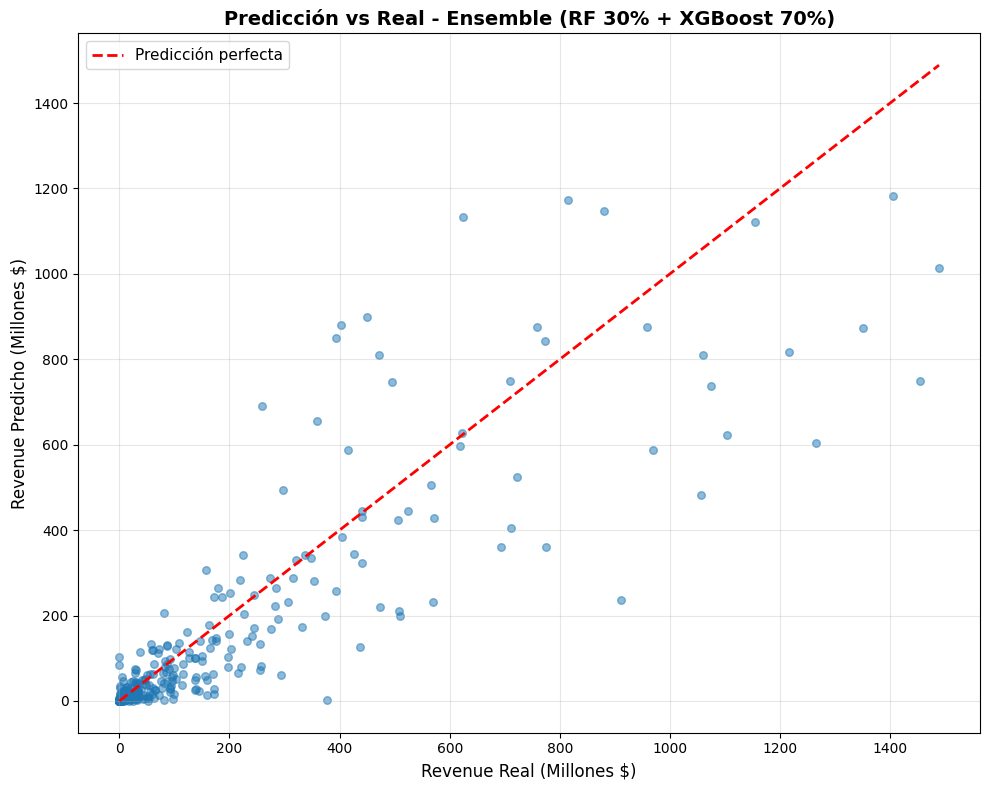

In [64]:
# Gráfico (train vs test)

plt.figure(figsize=(10, 8))
plt.scatter(y_test_original/1e6, y_pred_ensemble/1e6, alpha=0.5, s=30)

# Línea de predicción perfecta
max_val = max(y_test_original.max(), y_pred_ensemble.max()) / 1e6
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Predicción perfecta')

plt.xlabel('Revenue Real (Millones $)', fontsize=12)
plt.ylabel('Revenue Predicho (Millones $)', fontsize=12)
plt.title('Predicción vs Real - Ensemble (RF 30% + XGBoost 70%)', fontsize=14, weight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show();

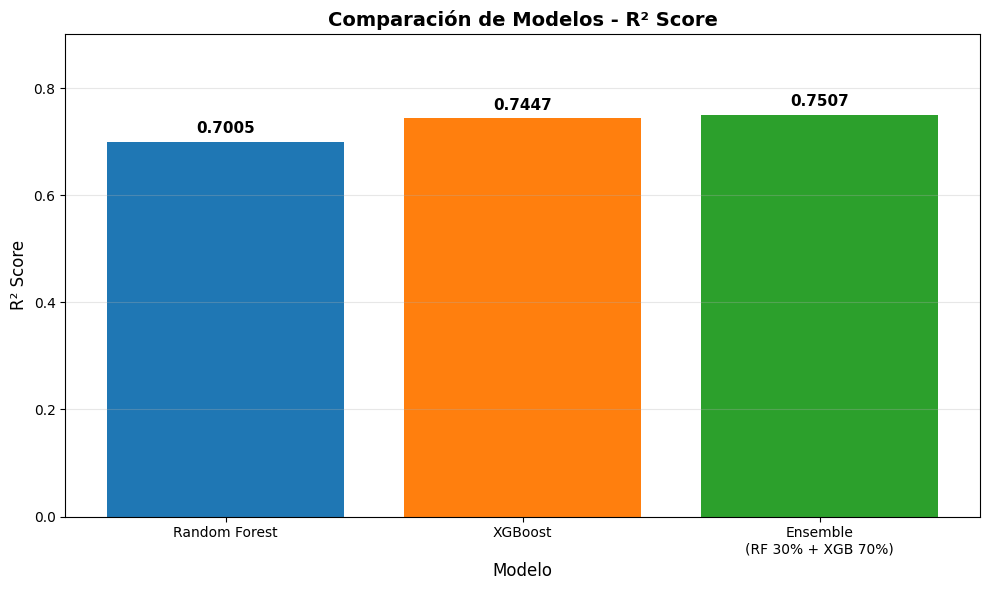

In [63]:
# Comparamos los diferentes modelos de regresión

modelos = ['Random Forest', 'XGBoost', 'Ensemble\n(RF 30% + XGB 70%)']
r2_values = [r2_rf_reg, r2_xgb_reg, r2_ensemble]  

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, r2_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylim(0, max(r2_values) * 1.2)
plt.title('Comparación de Modelos - R² Score', fontsize=14, weight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Modelo', fontsize=12)

# Añadir valores encima de cada barra
for bar, valor in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{valor:.4f}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show();

Realizaremos ahora el Feature Importance para ambos modelos.

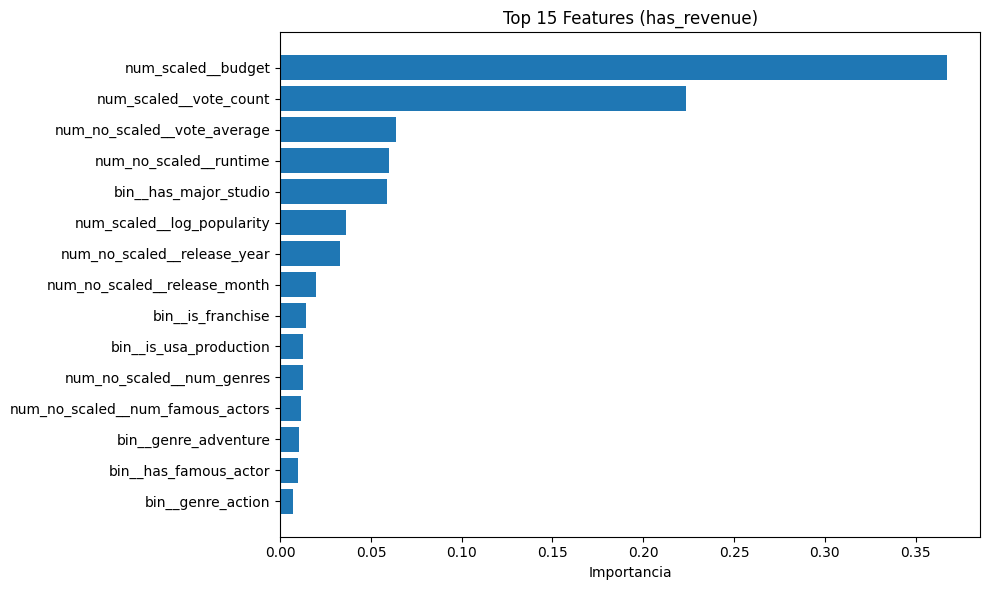

In [39]:
#Clasificación

# Obtenemos importancias
importances_clf = best_rf_clf.named_steps['classifier'].feature_importances_
feature_names_clf = best_rf_clf.named_steps['preprocessor'].get_feature_names_out()

# Creamos DataFrame
importance_clf_df = pd.DataFrame({
    'feature': feature_names_clf,
    'importance': importances_clf
}).sort_values('importance', ascending=False)

# Gráficos
plt.figure(figsize=(10, 6))
plt.barh(importance_clf_df['feature'][:15], importance_clf_df['importance'][:15])
plt.xlabel('Importancia')
plt.title('Top 15 Features (has_revenue)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show();

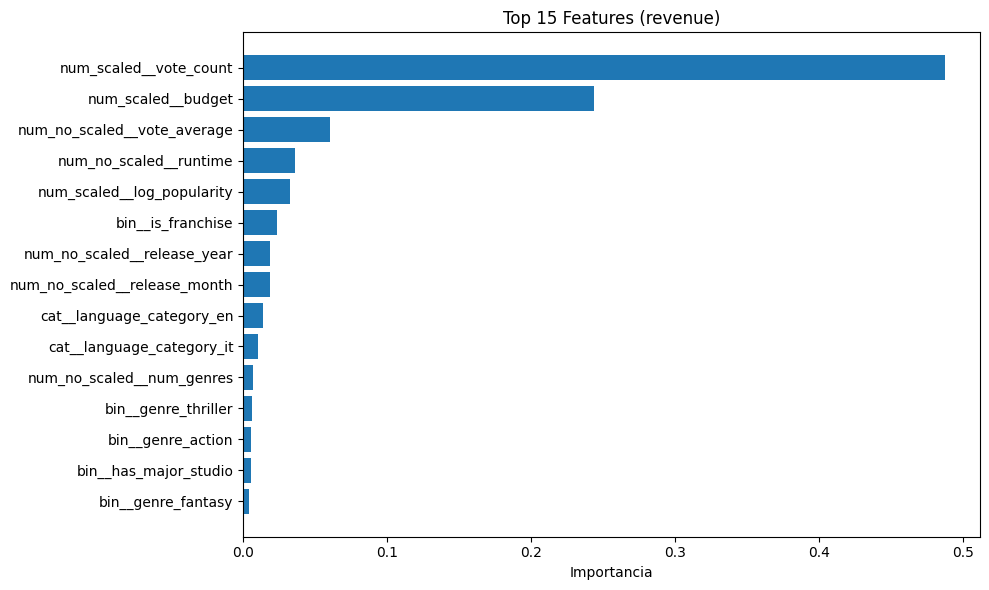

In [40]:
# Regresión

# Obtenemos importancias
importances_reg = best_rf_reg.named_steps['regressor'].feature_importances_
feature_names_reg = best_rf_reg.named_steps['preprocessor'].get_feature_names_out()

# Creamos DataFrame
importance_reg_df = pd.DataFrame({
    'feature': feature_names_reg,
    'importance': importances_reg
}).sort_values('importance', ascending=False)

# Gráficos
plt.figure(figsize=(10, 6))
plt.barh(importance_reg_df['feature'][:15], importance_reg_df['importance'][:15])
plt.xlabel('Importancia')
plt.title('Top 15 Features (revenue)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show();

Observamos que las dos columnas más importantes son claramente vote_count y budget.

Por último, haremos un modelo no supervisado de Machine Learning. En este caso, utilizaremos K-Means.

In [41]:
#K-Means

X_clustering = pd.concat([X_train_reg, X_test_reg], axis=0)
y_clustering = pd.concat([y_train_reg, y_test_reg], axis=0)

# Aplicamos el preprocessor

X_clustering_scaled = preprocessor.fit_transform(X_clustering)


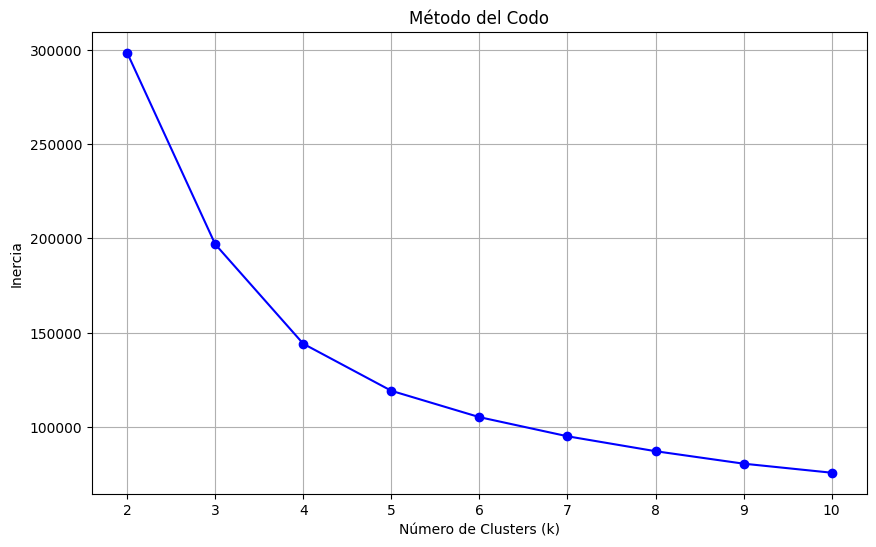

In [42]:
# Método del codo

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_clustering_scaled)
    inertias.append(kmeans_temp.inertia_)

# Visualizamos el método del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show();

In [43]:
# Entrenamos K-Means con k óptimo

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_clustering_scaled)

In [44]:
# Añadimos los clusters al dataset original

# Reconstruimos el dataset completo
full_df = pd.concat([
    pd.DataFrame(X_train_reg, columns=X_train_reg.columns),
    pd.DataFrame(X_test_reg, columns=X_test_reg.columns)
], axis=0).reset_index(drop=True)

full_df['cluster'] = clusters
full_df['revenue'] = np.exp(y_clustering.values) # Volvemos a la escala original

In [45]:
# Perfilamos cada cluster

cluster_profiles = full_df.groupby('cluster').agg({
    'budget': 'mean',
    'runtime': 'mean',
    'vote_average': 'mean',
    'vote_count': 'mean',
    'revenue': 'mean',
    'is_franchise': 'mean',
    'has_major_studio': 'mean',
    'is_usa_production': 'mean'
})
print(cluster_profiles)

               budget     runtime  vote_average   vote_count       revenue  \
cluster                                                                      
0        7.669302e+07  131.024725      7.030019  6096.719780  2.733191e+08   
1        2.677209e+07   92.833333      6.433087  2121.305556  9.165232e+07   
2        1.262712e+08  161.547368      7.242053  7549.452632  4.278070e+08   
3        4.521548e+07  109.991625      6.707358  3813.678392  1.460951e+08   

         is_franchise  has_major_studio  is_usa_production  
cluster                                                     
0            0.417582          0.425824           0.763736  
1            0.274306          0.194444           0.776042  
2            0.494737          0.452632           0.736842  
3            0.313233          0.316583           0.798995  


<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'PC1 (90.8% varianza)')

Text(0, 0.5, 'PC2 (5.1% varianza)')

Text(0.5, 1.0, 'Visualización de Clusters')

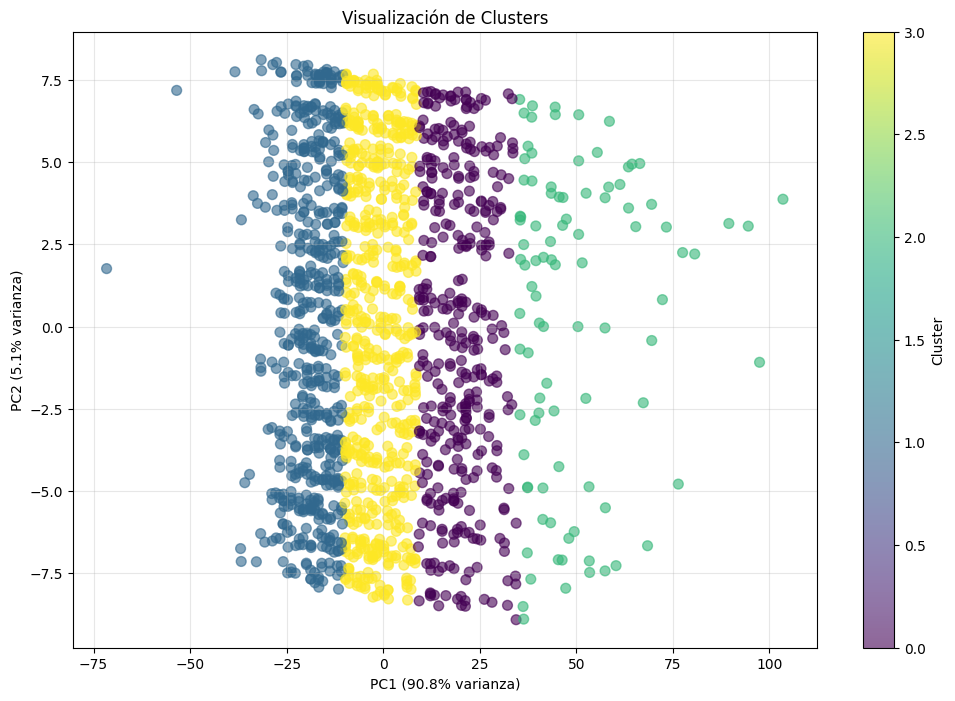


Varianza explicada por PCA:
PC1: 90.8%
PC2: 5.1%
Total: 95.9%


In [46]:
# Visualización de clusters

# Usamos PCA para reducir a 2 dimensiones y visualizar

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering_scaled)

# Gráfico
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)')
plt.title('Visualización de Clusters')
plt.grid(True, alpha=0.3)
plt.show();

print(f"\nVarianza explicada por PCA:")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.1f}%")

In [ ]:
# Interpretación de clusters

print("Interpretación de clusters :")

for cluster_id in range(n_clusters):
    cluster_data = full_df[full_df['cluster'] == cluster_id]
    
    print(f"Cluster {cluster_id}")
    print(f"Tamaño: {len(cluster_data)} películas ({len(cluster_data)/len(full_df)*100:.1f}%)")
    print(f"Budget promedio: ${cluster_data['budget'].mean()/1e6:.1f}M")
    print(f"Revenue promedio: ${cluster_data['revenue'].mean()/1e6:.1f}M")
    print(f"Vote average: {cluster_data['vote_average'].mean():.2f}")
    print(f"Franchises: {cluster_data['is_franchise'].mean()*100:.1f}%")
    print(f"Major studios: {cluster_data['has_major_studio'].mean()*100:.1f}%")
    print()


Interpretación de clusters:

Cluster 0
Tamaño: 364 películas (22.3%)
Budget promedio: $76.7M
Revenue promedio: $273.3M
Vote average: 7.03
Franchises: 41.8%
Major studios: 42.6%

Cluster 1
Tamaño: 576 películas (35.3%)
Budget promedio: $26.8M
Revenue promedio: $91.7M
Vote average: 6.43
Franchises: 27.4%
Major studios: 19.4%

Cluster 2
Tamaño: 95 películas (5.8%)
Budget promedio: $126.3M
Revenue promedio: $427.8M
Vote average: 7.24
Franchises: 49.5%
Major studios: 45.3%

Cluster 3
Tamaño: 597 películas (36.6%)
Budget promedio: $45.2M
Revenue promedio: $146.1M
Vote average: 6.71
Franchises: 31.3%
Major studios: 31.7%



Se aplicó K-Means con k=4 clusters, determinado mediante el método del codo, 
para segmentar el mercado según el presupuesto, revenue y características de producción.
Cluster 2 - Mega-Blockbusters (5.8%):
Producciones de élite con inversión promedio de $126M y revenue de $428M. Alta concentración de franchises (49.5%) y major studios (45.3%). Representa las apuestas más grandes de la industria con el mayor riesgo pero también el mayor retorno absoluto. Calidad superior (7.24/10).
Cluster 0 - Películas comerciales de éxito (22.3%):
Producciones sólidas con budget de $77M y revenue de $273M. Balance óptimo entre inversión y retorno. Franchises (41.8%) y major studios (42.6%) bien representados. Calidad alta (7.03/10).
Cluster 3 - Mainstream (36.6%):
El segmento más grande del mercado comercial. Budget moderado ($45M) con revenue aceptable ($146M).
Cluster 1 - Indies Comerciales (35.3%):
Producciones de bajo presupuesto ($27M) con revenue modesto ($92M). Menor presencia de major studios (19.4%).

In [48]:
silhouette = silhouette_score(X_clustering_scaled, clusters)
print("Silhouette Score :", silhouette)

Silhouette Score : 0.365180051234552


El Silhouette Score de 0.365 indica separación moderada entre clusters, lo cual es esperado en un mercado cinematográfico donde las categorías presentan 
transiciones graduales que dependen de muchos factores.

In [49]:
# Definimos nombres de clusters

cluster_names = {
    0: "Película comercial de éxito",
    1: "Indie Comercial", 
    2: "Mega-Blockbuster",
    3: "Mainstream"
}

# Añadimos columna con nombres al dataset
full_df['cluster_name'] = full_df['cluster'].map(cluster_names)

In [50]:
def predecir_pelicula(budget, runtime, vote_average, vote_count, release_year,
                      is_franchise=0, has_major_studio=0,
                      genre_action=0, genre_adventure=0, genre_comedy=0, genre_drama=0):

    # Preparamos features con las columnas EXACTAS que necesita el modelo
    pelicula_features = {
        'budget': budget,
        'runtime': runtime,
        'vote_average': vote_average,
        'vote_count': vote_count,
        'is_franchise': is_franchise,
        'log_popularity': 3.0,
        'language_category': 'en', 
        'release_year': release_year,
        'release_month': 6, 
        'num_genres': sum([genre_action, genre_adventure, genre_comedy, genre_drama]),
        'genre_action': genre_action,
        'genre_adventure': genre_adventure,
        'genre_animation': 0,
        'genre_comedy': genre_comedy,
        'genre_horror': 0,
        'genre_drama': genre_drama,
        'genre_family': 0,
        'genre_fantasy': 0,
        'genre_science_fiction': 0,
        'genre_thriller': 0,
        'has_famous_actor': 0,
        'num_famous_actors': 2, 
        'is_usa_production': 1,  
        'has_major_studio': has_major_studio
    }
    
    pelicula_df = pd.DataFrame([pelicula_features])
    
    # Regresión
    y_pred_rf_log = best_rf_reg.predict(pelicula_df)
    y_pred_xgb_log = pipeline_xgb_reg.predict(pelicula_df)
    y_pred_ensemble_log = 0.6 * y_pred_rf_log + 0.4 * y_pred_xgb_log
    revenue_pred = np.exp(y_pred_ensemble_log)[0]
    
    # Clustering
    pelicula_scaled = preprocessor.transform(pelicula_df)
    cluster_id = kmeans.predict(pelicula_scaled)[0]
    segmento = cluster_names[cluster_id]
    
    return {
        'Revenue estimado': f"${revenue_pred/1e6:.1f}M",
        'Segmento': segmento
    }

In [65]:
# Ejemplo 1 Blockbuster

print(predecir_pelicula(
    budget=150000000, runtime=140, vote_average=7.5, 
    vote_count=8000, release_year=2025,
    is_franchise=1, has_major_studio=1,
    genre_action=1, genre_adventure=1
))

# Ejemplo 2 Indie

print(predecir_pelicula(
    budget=5000000, runtime=105, vote_average=7.2,
    vote_count=500, release_year=2025,
    genre_drama=1
))

# Ejemplo 3 Mainstream

print(predecir_pelicula(
    budget=40000000, runtime=115, vote_average=6.8,
    vote_count=2000, release_year=2025,
    genre_comedy=1
))

{'Revenue estimado': '$662.8M', 'Segmento': 'Película comercial de éxito'}
{'Revenue estimado': '$4.6M', 'Segmento': 'Mainstream'}
{'Revenue estimado': '$48.2M', 'Segmento': 'Mainstream'}


A continuación, guardaremos nuestros 3 modelos.

In [52]:
# Clasificación
with open('modelo_clasificacion.pkl', 'wb') as f:
    pickle.dump(best_rf_clf, f)


In [53]:
# Regresión 
modelos_regresion = {
    'rf': best_rf_reg,
    'xgb': pipeline_xgb_reg,
    'pesos': {'rf': 0.3, 'xgb': 0.7}
}
with open('modelo_regresion.pkl', 'wb') as f:
    pickle.dump(modelos_regresion, f)

In [54]:
# K-Means
modelo_clustering = {
    'kmeans': kmeans,
    'preprocessor': preprocessor,
    'nombres': cluster_names
}
with open('modelo_clustering.pkl', 'wb') as f:
    pickle.dump(modelo_clustering, f)

Para finalizar el proyecto, haremos un pipeline que una los dos modelos supervisados. Este será el modelo mixto del que hemos hablado al principio

In [55]:
class MoviePredictor:

    def __init__(self):
        self.clf = pickle.load(open('modelo_clasificacion.pkl', 'rb'))
        self.reg = pickle.load(open('modelo_regresion.pkl', 'rb'))
    
    def preparar_features(self, budget, runtime, vote_average, vote_count, release_year,
                          is_franchise=0, has_major_studio=0,
                          genre_action=0, genre_adventure=0, genre_comedy=0, genre_drama=0):
        
        return pd.DataFrame([{
            'budget': budget, 'runtime': runtime, 'vote_average': vote_average,
            'vote_count': vote_count, 'is_franchise': is_franchise,
            'log_popularity': 3.0, 'language_category': 'en',
            'release_year': release_year, 'release_month': 6,
            'num_genres': sum([genre_action, genre_adventure, genre_comedy, genre_drama]),
            'genre_action': genre_action, 'genre_adventure': genre_adventure,
            'genre_animation': 0, 'genre_comedy': genre_comedy, 'genre_horror': 0,
            'genre_drama': genre_drama, 'genre_family': 0, 'genre_fantasy': 0,
            'genre_science_fiction': 0, 'genre_thriller': 0,
            'has_famous_actor': 0, 'num_famous_actors': 2,
            'is_usa_production': 1, 'has_major_studio': has_major_studio
        }])
    
    def predecir(self, budget, runtime, vote_average, vote_count, release_year,
                 is_franchise=0, has_major_studio=0,
                 genre_action=0, genre_adventure=0, genre_comedy=0, genre_drama=0):
        
        X = self.preparar_features(budget, runtime, vote_average, vote_count, release_year,
                                    is_franchise, has_major_studio,
                                    genre_action, genre_adventure, genre_comedy, genre_drama)
        
        # Clasificación
        va_a_cines = self.clf.predict(X)[0]
        probabilidad = self.clf.predict_proba(X)[0][1]
        
        # Regresión (solo si va a cines)
        if va_a_cines == 1:
            pred_rf_log = self.reg['rf'].predict(X)
            pred_xgb_log = self.reg['xgb'].predict(X)
            revenue = np.exp(0.6 * pred_rf_log + 0.4 * pred_xgb_log)[0]
        else:
            revenue = 0
        
        return {
            'va_a_cines': bool(va_a_cines),
            'probabilidad': float(probabilidad),
            'revenue': float(revenue)
        }

In [56]:
# Guardar
pipeline = MoviePredictor()
with open('moviepredictor.pkl', 'wb') as f:
    pickle.dump(pipeline, f)